# Motivation 

Several meteorological and land surface factors have been found to impact Saharan dust emissions and transport. Dust mobilization occurs when surface wind speed of suitable magnitude is above a threshold velocity, often computed based on soil characteristics, vegetation, and solid particles (cite here). The purpose of this cookbook is to understand the relationship between dust and some meteorological variables. The question we are really interested in this cookbook to know which variables are the most predictive of dust emissions. 

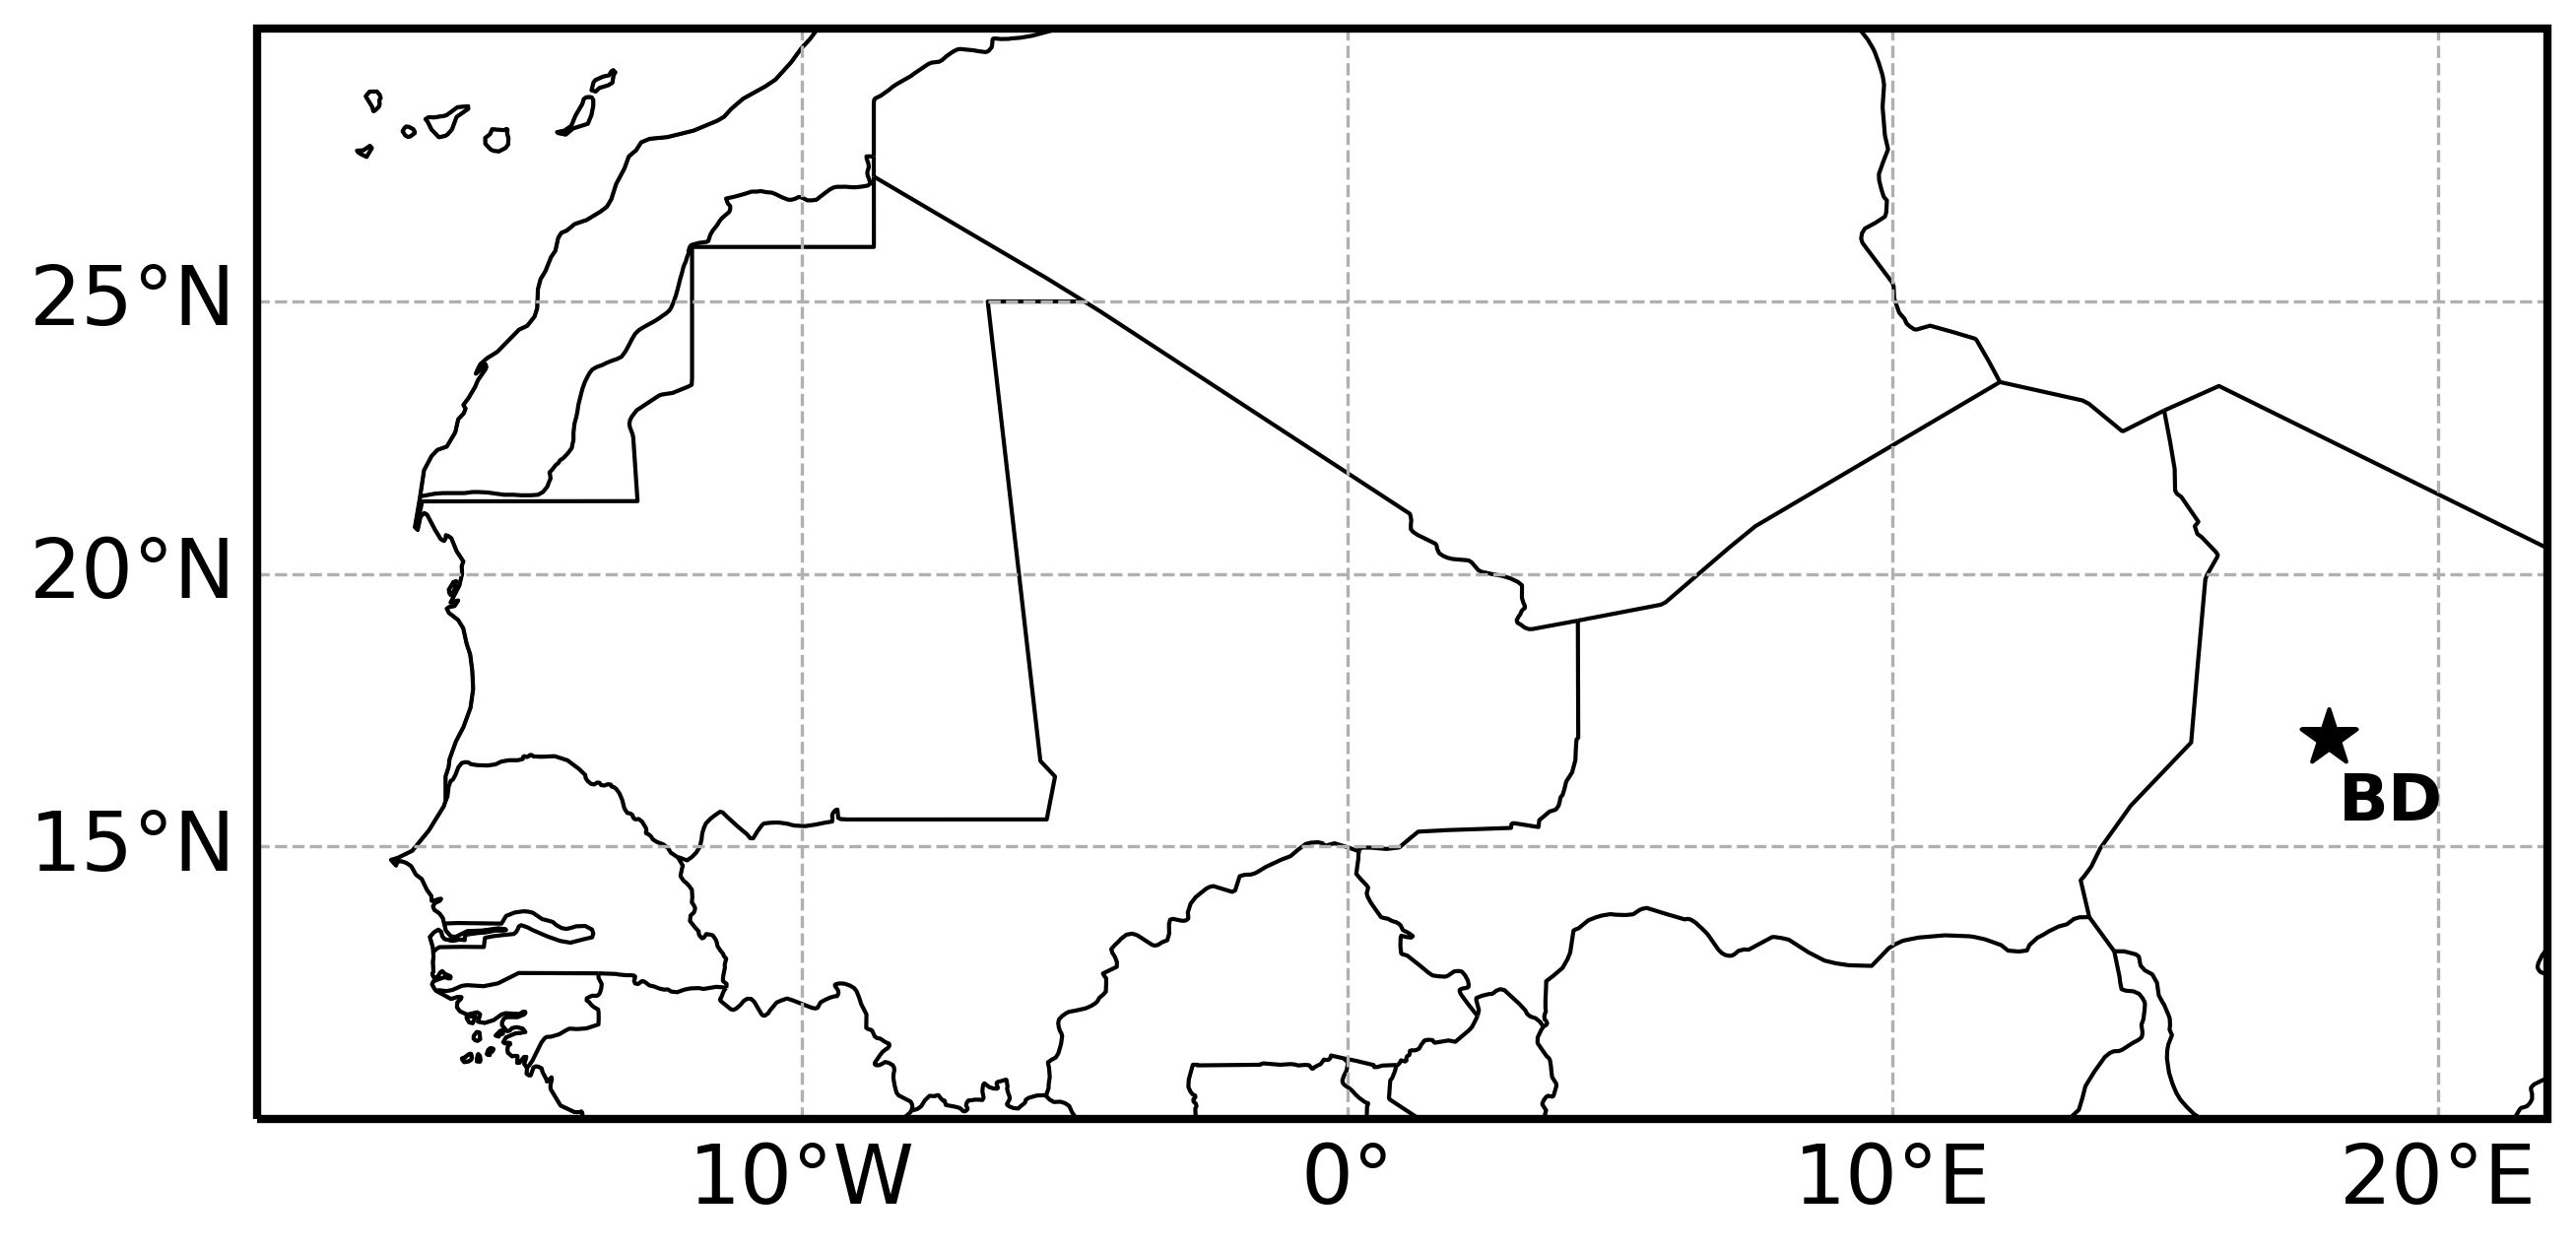

For experimenting purpose, we consider PM<sub>10<sub> concentration, 2m temperature (T2), 2m relative humidity, planetary boundary layer height, 10m wind speed, 925hPa wind speed, horizontal wind, meridional wind, and convective rainfall. This cookbook seeks to establish a clear relationship between the meteorological variables and dust (PM10).  

In [6]:
# load python packages
import numpy as np
import pandas as pd
import xarray as xr
import math

# load machine learning packages
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

# minisom package for SOM
!pip install minisom
import minisom
from minisom import MiniSom

from pylab import bone, pcolor, colorbar, plot, show
from matplotlib.patches import Patch

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import matplotlib.cbook as cbook

In [26]:
# customize figure 
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

In [29]:
# little function

def remove_time_mean(x):
    return x - x.mean(dim='time')

# Importing data from disk

In [4]:
path='./'
dust_df = pd.read_csv(path+'saharan_dust_met_vars.csv', index_col='time')

# print out shape of data 
print('Shape of data:', np.shape(dust_df))

# print first 5 rows of data
print(dust_df.head())
feature_names = dust_df.columns
pm_df = dust_df['PM10'].values

Shape of data: (18466, 10)
                 PM10         T2        rh2         slp       PBLH  RAINC  \
time                                                                        
1960-01-01  2000.1490  288.24875  32.923786  1018.89420  484.91812    0.0   
1960-01-02  4686.5370  288.88450  30.528862  1017.26575  601.58310    0.0   
1960-01-03  5847.7515  290.97128  26.504536  1015.83514  582.38540    0.0   
1960-01-04  5252.0586  292.20060  30.678936  1013.92230  555.11860    0.0   
1960-01-05  3379.3190  293.06076  27.790462  1011.94934  394.95440    0.0   

            wind_speed_10m  wind_speed_925hPa       U10       V10  
time                                                               
1960-01-01        6.801503          13.483623 -4.671345 -4.943579  
1960-01-02        8.316340          18.027075 -6.334070 -5.388977  
1960-01-03        9.148216          17.995173 -6.701636 -6.227193  
1960-01-04        8.751743          15.806478 -6.387379 -5.982842  
1960-01-05        6.39322

In [58]:
dust_df_new =dust_df.reset_index()
dust_df_new['time'] = pd.to_datetime(dust_df_new['time'])
dust_df_final = dust_df_new.set_index('time')
dust_df_nc = dust_df_final.to_xarray()

dust_deseas = dust_df_nc.groupby('time.dayofyear').apply(remove_time_mean).to_dataframe()

# Variables exploration

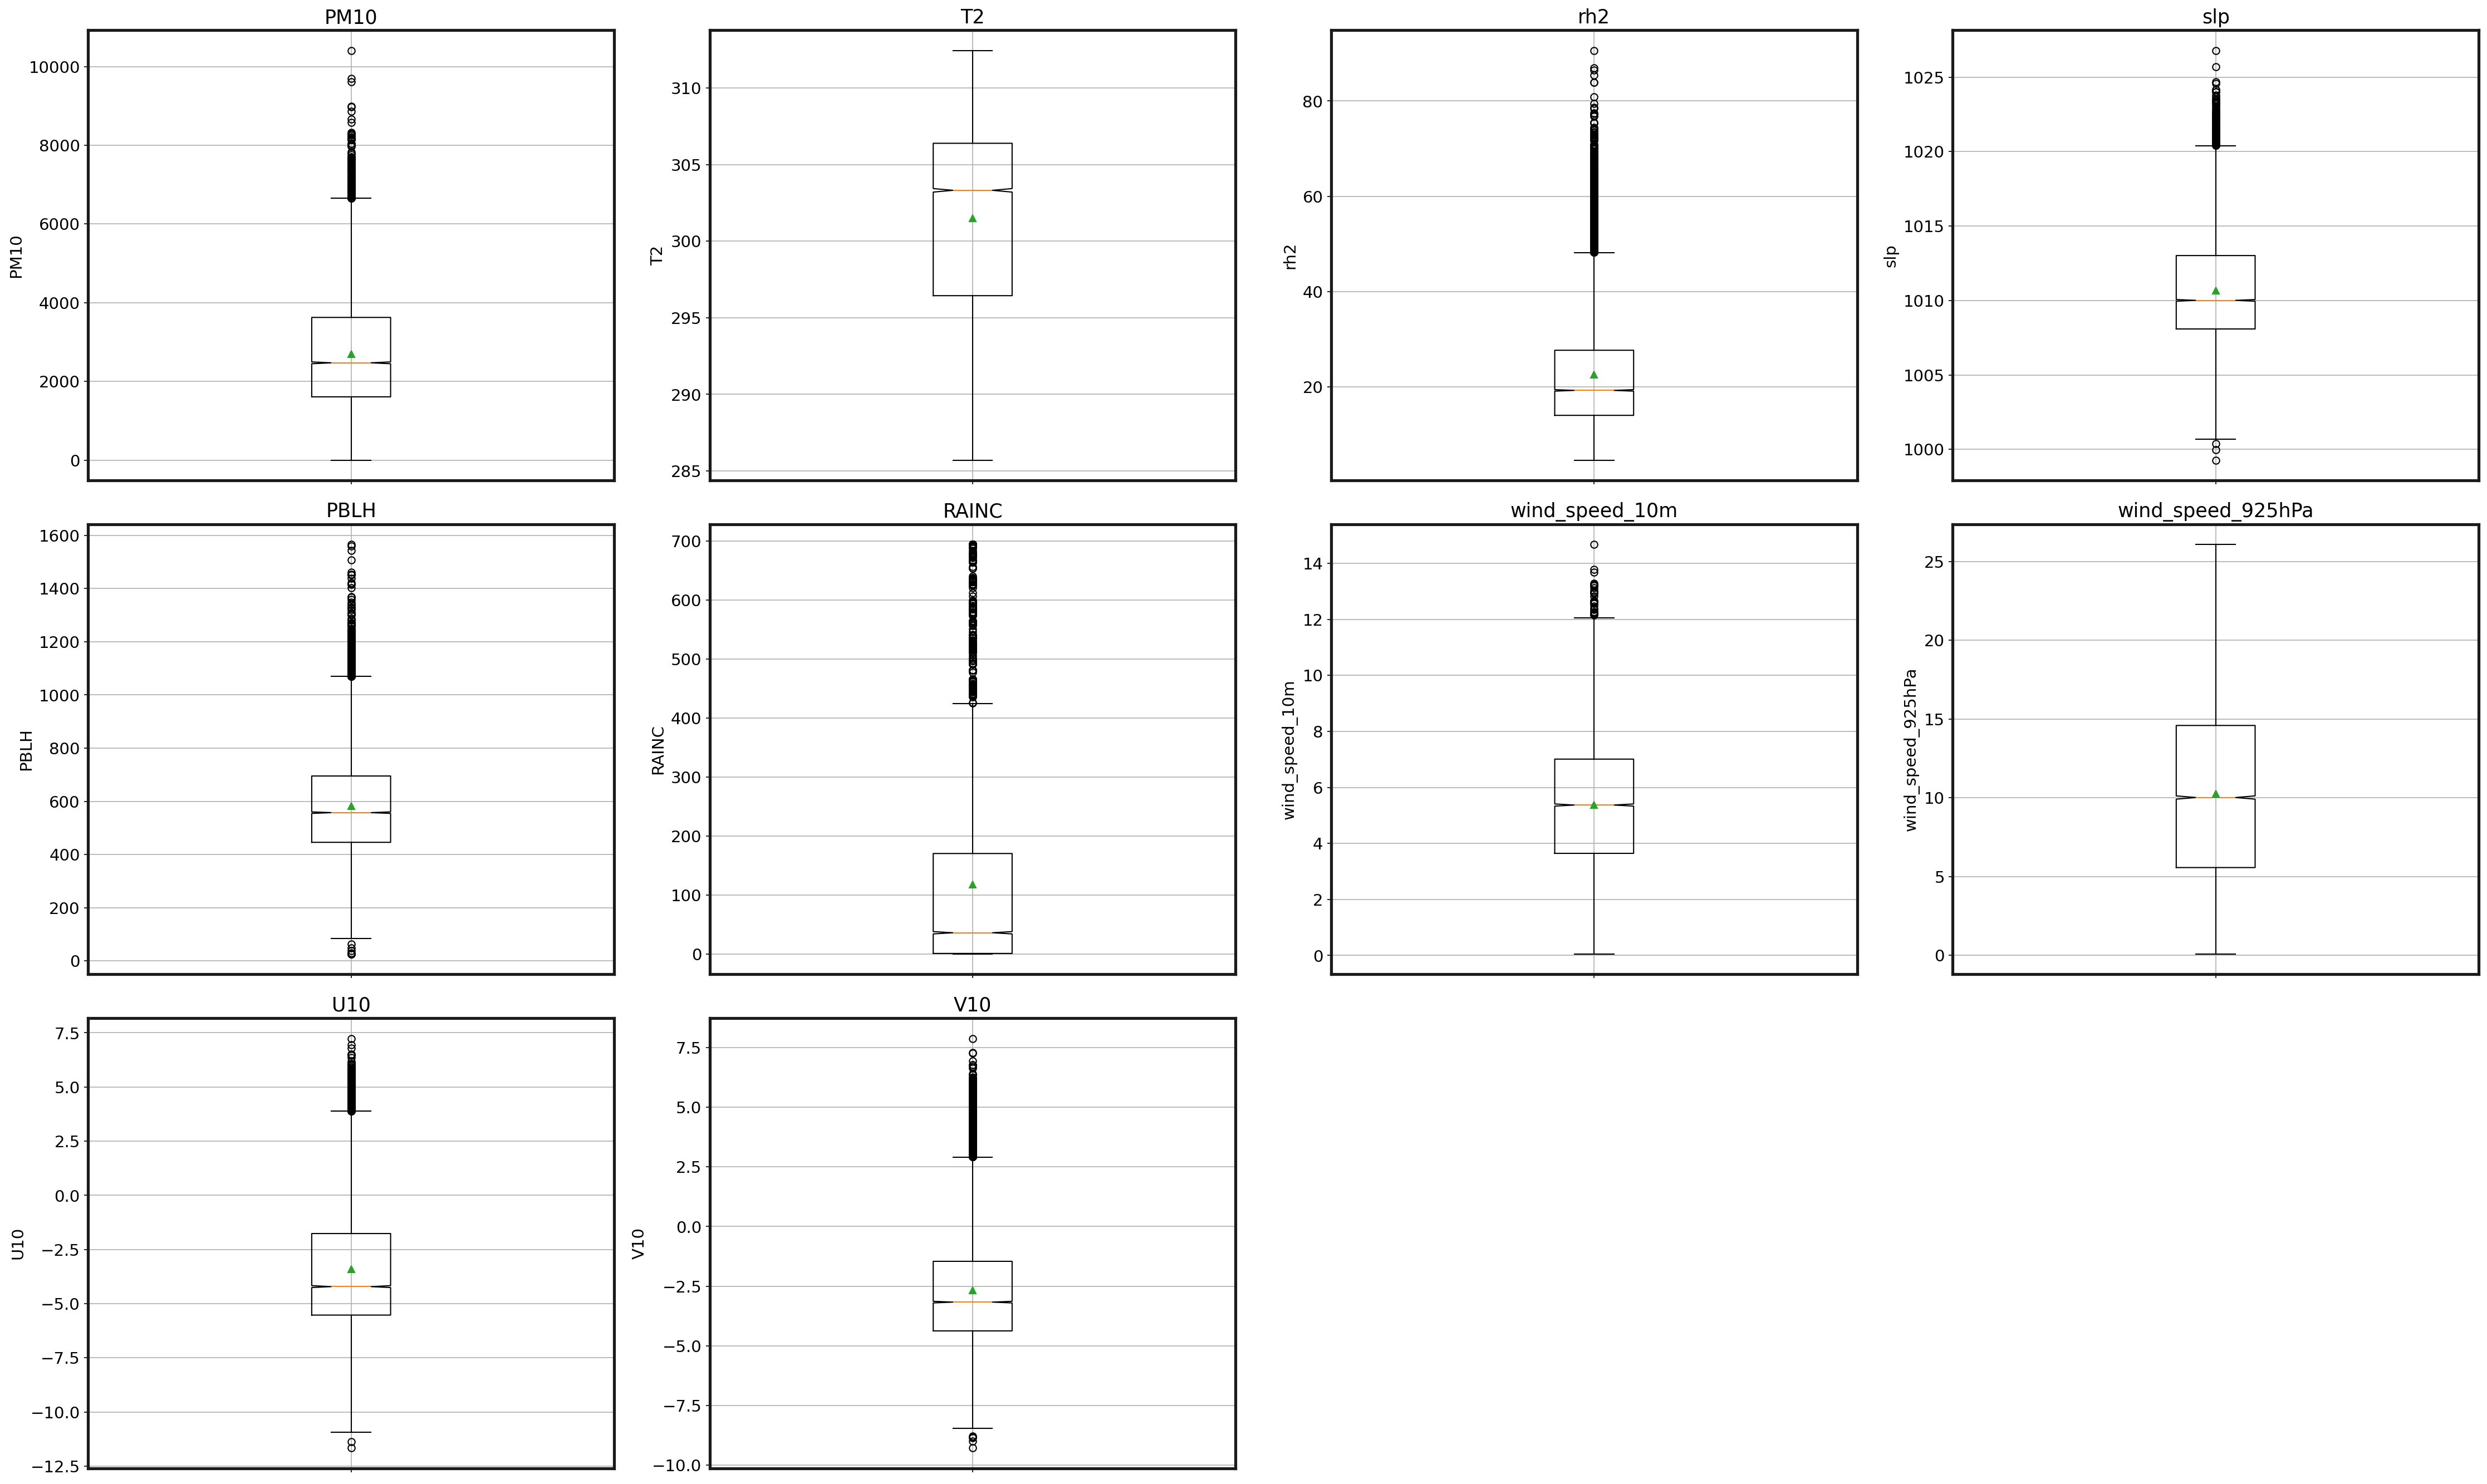

In [28]:
fig, ax = plt.subplots(3,4, figsize=(30,18))
ax = ax.flatten()
for ind, col in enumerate(feature_names):
    ax[ind].boxplot(dust_df[col].dropna(axis=0), 
                    notch=True, whis=1.5,  
                    showmeans=True)
    ax[ind].grid(which='minor', axis='both')
    ax[ind].set_xticklabels([''])
    ax[ind].set_ylabel(col)
    ax[ind].set_title(col)
    ax[ind].set_facecolor('white')
    ax[ind].spines['bottom'].set_color('0.1')
    ax[ind].spines['top'].set_color('0.1')
    ax[ind].spines['right'].set_color('0.1')
    ax[ind].spines['left'].set_color('0.1')
    ax[ind].grid(True)
    ax[10].set_axis_off()
    ax[11].set_axis_off()
fig.tight_layout()
#plt.savefig('../../graphs/box_plots_with_outliers_deseas_mon.png')

# Scaling the variables

As you can see there is a large range of values among variables. SOM is scale variant, so To not influence the results as it is the case in many unsupervised machine learning models, it is important to scale them. Many scaling methods exist but I am using the minmax scaler.

In [4]:
# testing between standardization and normalization scaling 

# normalization by minmax scaling 
minmax_sc = preprocessing.MinMaxScaler(feature_range = (0, 1))
minmax_sc.fit(dust_df)
minmax_scaled_df = minmax_sc.transform(dust_df)

# standardization
std_sc = preprocessing.StandardScaler().fit(dust_df)
std_scaled_df = std_sc.transform(dust_df)

# Robust scaling for outliers
rb_sc = preprocessing.RobustScaler().fit(dust_df)
rob_scaled_df = rb_sc.transform(dust_df)

# Define map and train the SOM map

Recommended map size: 5*sqrt(number_of_samples)

In [18]:
# training data
train_data = rob_scaled_df
# Define minisom model
n_samples = train_data.shape[1] 
num = math.ceil(5*math.sqrt(n_samples))
som = MiniSom(x=num, # map size
              y=num, # map size, NxN
              input_len=10, # 10 element input vectors
              sigma=3.,
              learning_rate=0.5, 
              neighborhood_function='gaussian', # a few options for this
             topology='hexagonal', 
              activation_distance='euclidean', 
              random_seed=10)

# input_len: number of features used for training the model
# sigma: is the radius of the different neighbors in the SOM
# learning rate: determines how much the weights are adjusted during each iterations

# initilize weights using PCA
# You could also do that using random_weights_init, but the advantage is that PCA is likely to converge faster
#som.pca_weights_init(scaled_dust_df)  # prefrerred
som.random_weights_init(train_data)

## training the SOM : there are two type of training
# 1. train_random: trains model by pickinhg random data from the data
# 2. train_batch: trains model from samples in the order in which they are fed.

som.train(data = train_data, num_iteration = 25000, 
          verbose=True, random_order=True) #

 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.7955823980825105


# Visualizing the Results

## Neighbour distance 

The neighbor distance is also as the “U-Matrix”. It is the distance between each node and its neighbours. Regions of low neighbour distance indicate groups of nodes that are similar, while regions of large distances indicate nodes are much more different — and indicate natural boundaries between node clusters. The U-Matrix can be used to identify clusters within the SOM map.

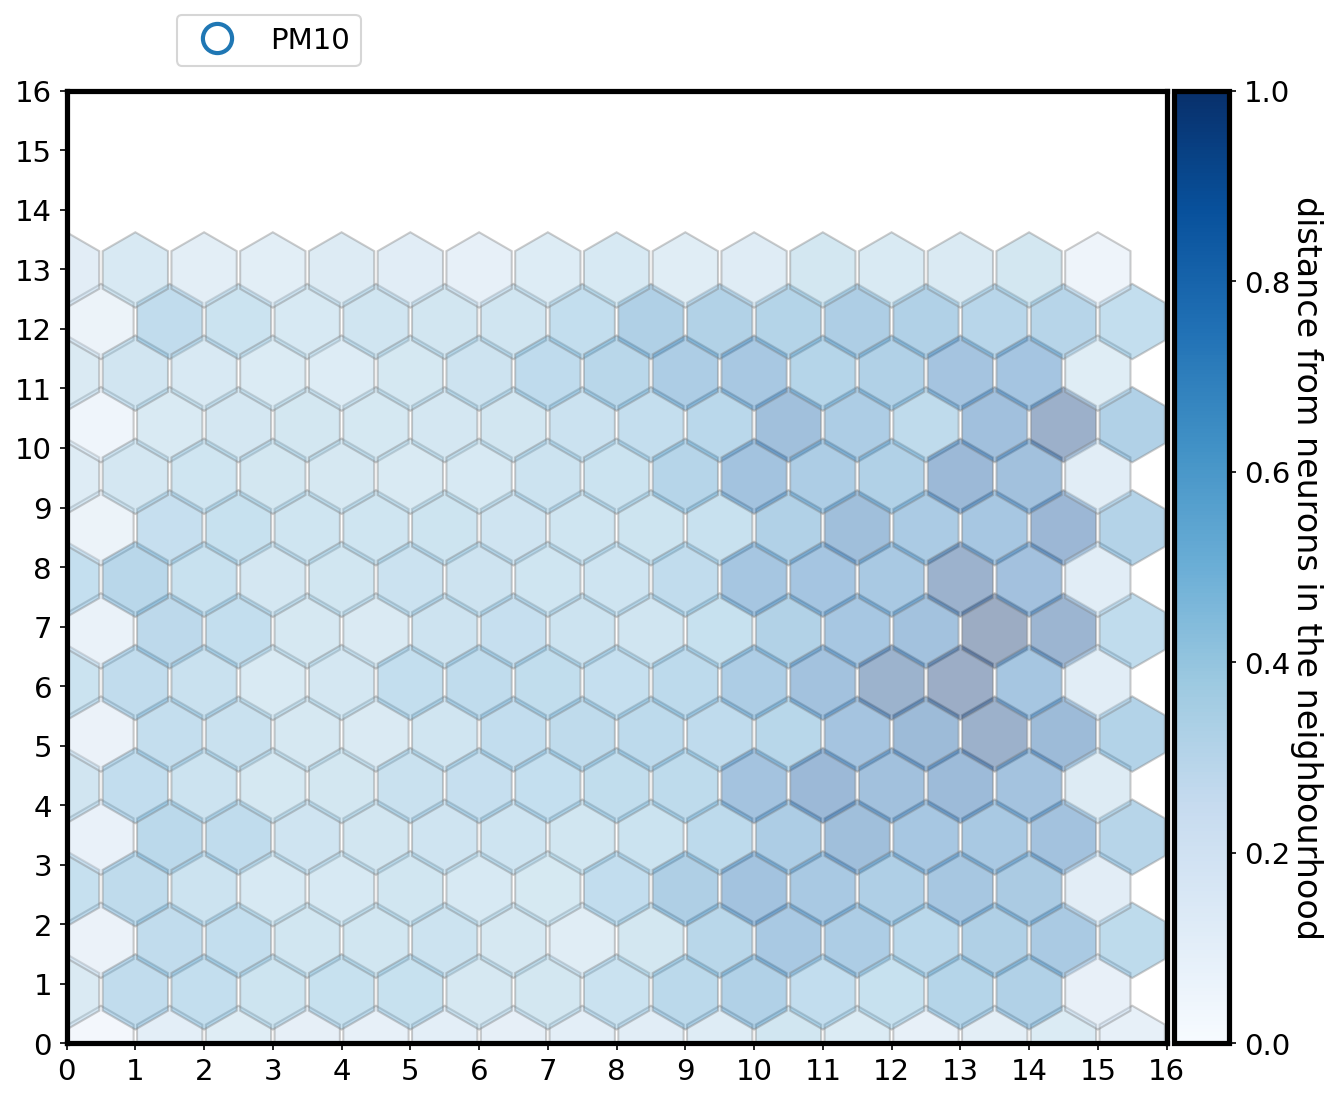

In [19]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

markers = ['o']
colors = ['C0']
# for cnt, x in enumerate(train_data):
#     # getting the winner
#     w = som.winner(x)
#     # place a marker on the winning position for the sample xx
#     wx, wy = som.convert_map_to_euclidean(w) 
#     wy = wy * np.sqrt(3) / 2
#     plt.plot(wx, wy, 
#              markers[pm_df[cnt]-1], 
#              markerfacecolor='None',
#              markeredgecolor=colors[pm_df[cnt]-1], 
#              markersize=12, 
#              markeredgewidth=2)

xrange = np.arange(weights.shape[0]+1)
yrange = np.arange(weights.shape[1]+1)
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='PM10',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
                   # Line2D([0], [0], marker='+', color='C1', label='Rosa',
                   # markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   # Line2D([0], [0], marker='x', color='C2', label='Canadian',
                   # markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=1, fontsize=14)

#plt.savefig('resulting_images/som_seed_hex.png')
#plt.show()

In [9]:
# bone()
# pcolor(som.distance_map().T, cmap='bone_r')
# colorbar()
# markers = ['o', 's']
# colors = ['r', 'g']

# for i, x in enumerate(minmax_scaled_df):
#     #print(i)
#     w = som.winner(x)
#     plot(w[0]+0.5,
#          w[1]+0.5,
#          markers[pm_loc[i]],
#          markeredgecolor = colors[pm_loc[i]],
#          markerfacecolor = 'None',
#          markersize=10,
#          markeredgewidth=2)

In [10]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 10))
# #plt.subplot(5, 2, i+1)
# #ax.set_title(titles[i])
# ax.pcolor(som.distance_map().T, cmap='coolwarm')
# #plt.colorbar()
# #ax[i].set_xticks(np.arange(num+1))
# #ax[i].set_yticks(np.arange(num+1))

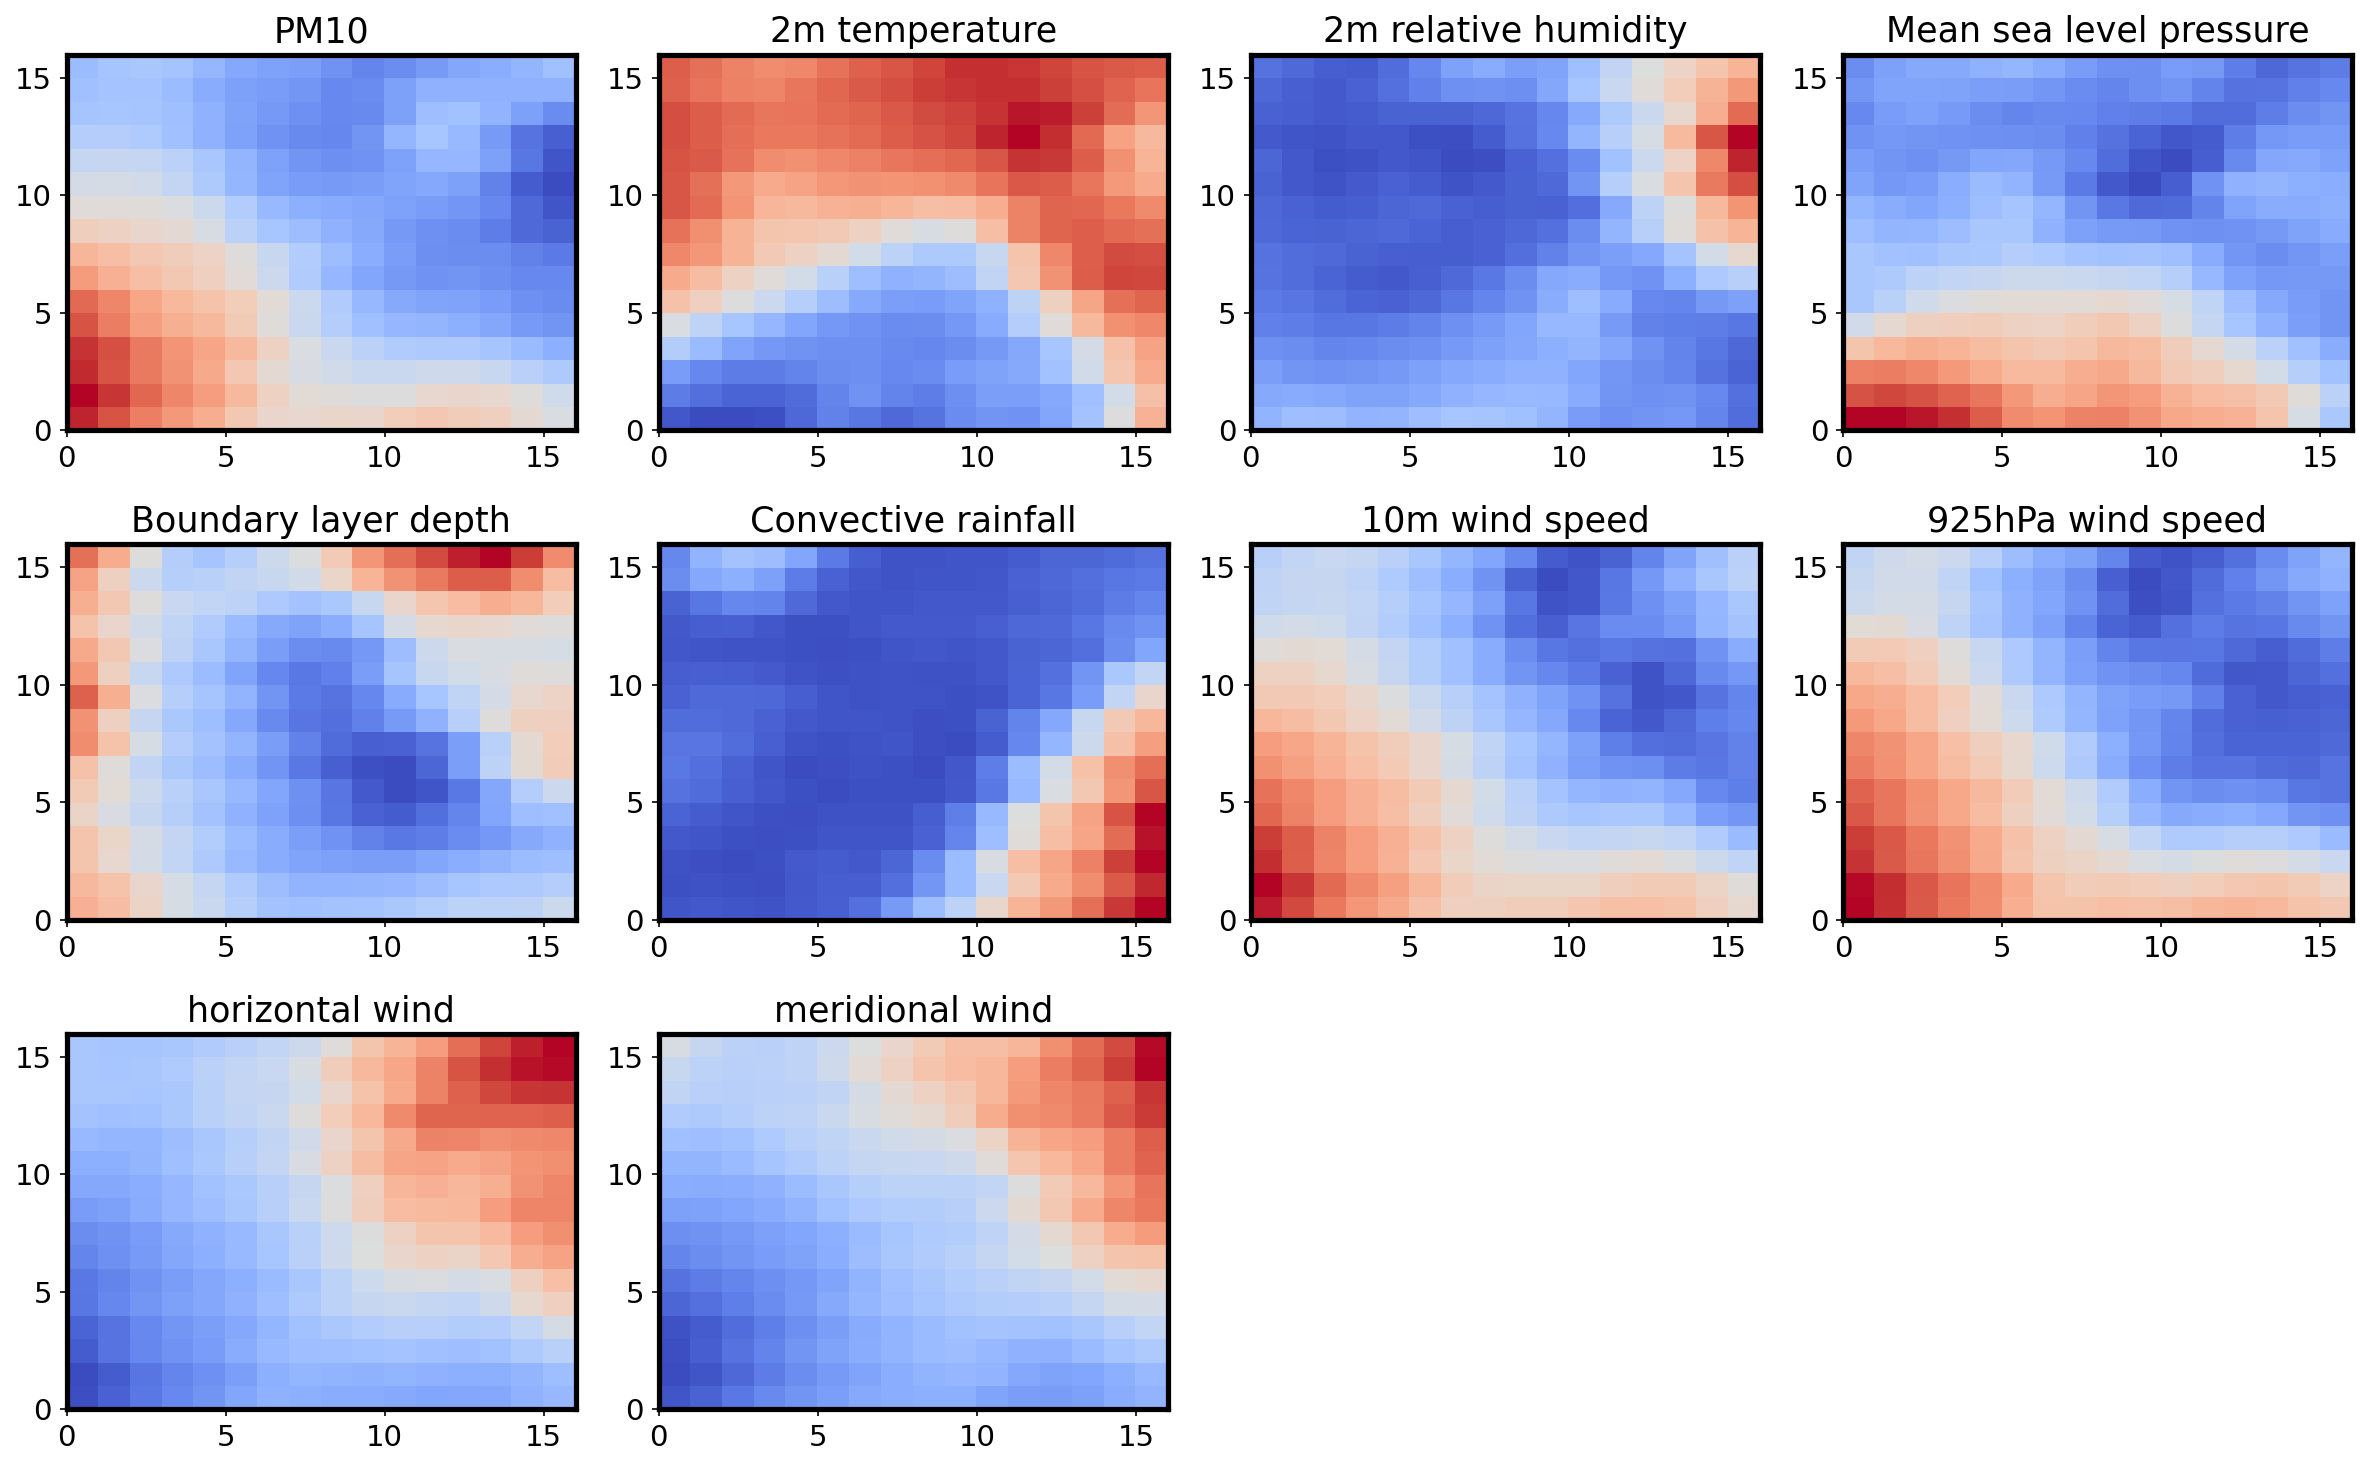

In [20]:
titles = ['PM10', '2m temperature', '2m relative humidity', 'Mean sea level pressure', 'Boundary layer depth', 
          'Convective rainfall', '10m wind speed', '925hPa wind speed', 'horizontal wind', 'meridional wind']
W = som.get_weights()
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()
for i, f in enumerate(feature_names):
    #plt.subplot(5, 2, i+1)
    ax[i].set_title(titles[i])
    ax[i].pcolor(W[:,:,i].T, cmap='coolwarm')
    #ax[i].set_xticks(np.arange(num+1))
    #ax[i].set_yticks(np.arange(num+1))
ax[10].set_axis_off()
ax[11].set_axis_off()
plt.tight_layout()
plt.savefig('feature_patterns.png')

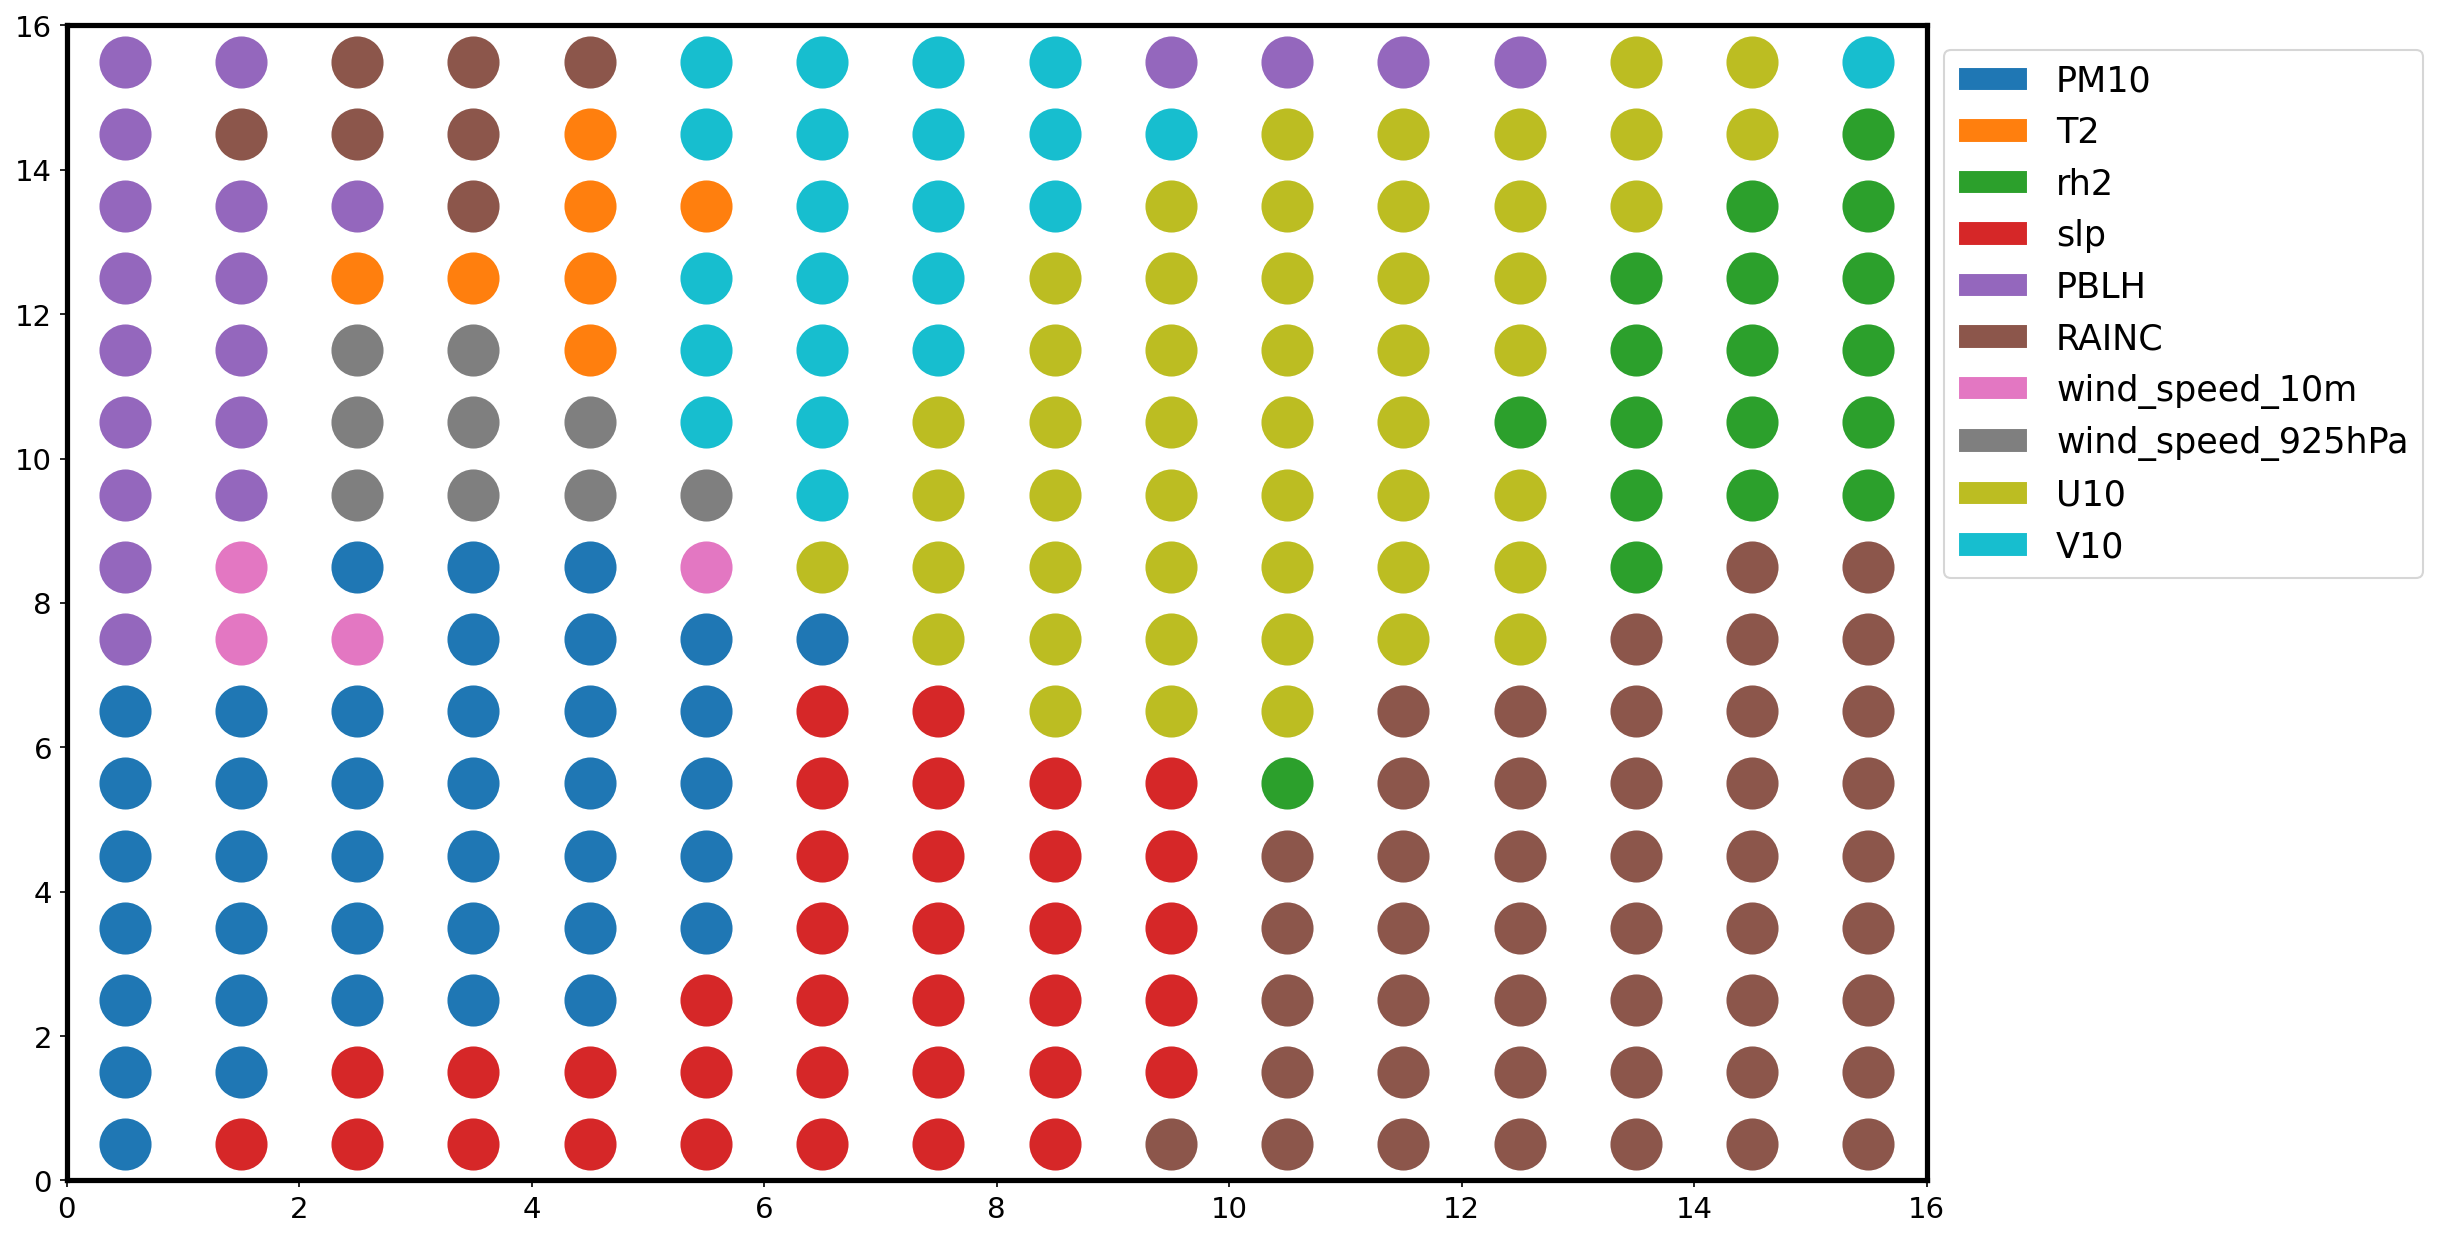

In [25]:
cols = np.array(['sandybrown', 'red', 'darkgreen', 'steelblue', 'magenta', 'lighseagreen', 'blue', 'slateblue', 'orange',
                'darkorange'])
Z = np.zeros((num, num))
plt.figure(figsize=(16, 10))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([i+.5], [j+.5], color='C'+str(feature),
                 marker='o', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .75))
        
plt.xlim([0, num])
plt.ylim([0, num])
plt.savefig('feature_importance.png')
plt.show()

In [13]:
len(W[:,:,0])

16

In [14]:
# clusters = [som.winner(data) for data in dust_df[:5000].values]
# clu = [(cl1+1)*(cl2+1) for cl1, cl2 in clusters]
# plt.plot(clu)
# print(clu)

In [15]:
dust_df[:365].values

array([[ 2.0001490e+03,  2.8824875e+02,  3.2923786e+01, ...,
         1.3483623e+01, -4.6713448e+00, -4.9435790e+00],
       [ 4.6865370e+03,  2.8888450e+02,  3.0528862e+01, ...,
         1.8027075e+01, -6.3340700e+00, -5.3889766e+00],
       [ 5.8477515e+03,  2.9097128e+02,  2.6504536e+01, ...,
         1.7995173e+01, -6.7016360e+00, -6.2271934e+00],
       ...,
       [ 4.9895830e+03,  2.9514746e+02,  2.1093610e+01, ...,
         1.1132390e+01, -1.5973161e+00, -3.8983903e+00],
       [ 6.0900020e+03,  2.9484283e+02,  3.3629223e+01, ...,
         1.8745201e+01, -8.0929980e+00, -6.4008610e+00],
       [ 3.4601165e+03,  2.9586273e+02,  2.7987598e+01, ...,
         1.2267728e+01, -4.6182904e+00, -5.2522006e+00]])

In [16]:
dust_df[:365].values

array([[ 2.0001490e+03,  2.8824875e+02,  3.2923786e+01, ...,
         1.3483623e+01, -4.6713448e+00, -4.9435790e+00],
       [ 4.6865370e+03,  2.8888450e+02,  3.0528862e+01, ...,
         1.8027075e+01, -6.3340700e+00, -5.3889766e+00],
       [ 5.8477515e+03,  2.9097128e+02,  2.6504536e+01, ...,
         1.7995173e+01, -6.7016360e+00, -6.2271934e+00],
       ...,
       [ 4.9895830e+03,  2.9514746e+02,  2.1093610e+01, ...,
         1.1132390e+01, -1.5973161e+00, -3.8983903e+00],
       [ 6.0900020e+03,  2.9484283e+02,  3.3629223e+01, ...,
         1.8745201e+01, -8.0929980e+00, -6.4008610e+00],
       [ 3.4601165e+03,  2.9586273e+02,  2.7987598e+01, ...,
         1.2267728e+01, -4.6182904e+00, -5.2522006e+00]])

TypeError: 'module' object is not callable

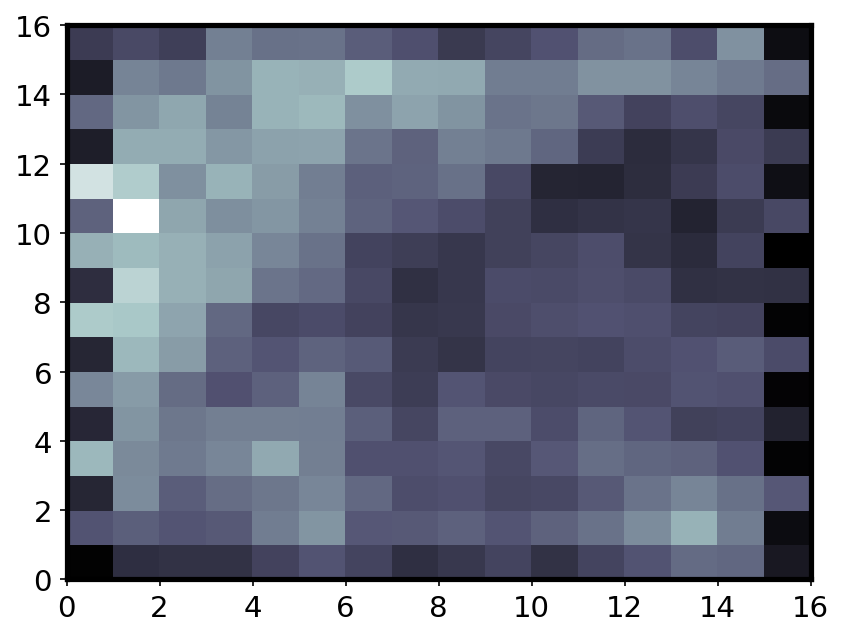

In [17]:
bone()
pcolor(som.distance_map().T)
colorbar()

# markers = ['o', 's']
# colors = ['r', 'g']

# for i, x in enumerate(scaled_dust_df):
#     w = som.winner(x)
#     # w[0], w[1] will place the marker at bottom left corner of the rectangle. 
#     #Let us add 0.5 to both of these to plot the market at the center of the rectange.
#     plot(w[0] + 0.5, 
#          w[1] + 0.5,
#          #Target value 0 will have marker "o" with color "r"
#          #Target value 1 will have marker "s" with color "g"
#          marker='o', 
#          markeredgecolor = 'r',
#          markerfacecolor = 'None', #No color fill inside markers
#          markersize = 10,
#          markeredgewidth = 2)
# show()


# Random Forest Regression

In [19]:
# Load packages
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Define a function for error calculations

In [20]:
def regression_stats(model_fit, model_name, features_test, pred, target_test):
  #Calculate and display model error
  score = model_fit.score(features_test,target_test)
  print('\n'+model_name)
  print(f'Score : {score}')
  print(f'MAE: {mean_absolute_error(pred,target_test)}')
  print(f'RMSE : {np.sqrt(mean_squared_error(pred,target_test))}')

In [21]:
target_vars = dust_df['PM10']   # PM10 concentration is the target variable
features = dust_df.drop(['PM10'], axis=1)  # remaining variables should be features

# split the data into 70% training and reserve 30% for testing
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                target_vars, test_size = 0.3)

# Now train the model using the training sets
rf = RandomForestRegressor(n_estimators=200,
                    random_state=42, n_jobs=-1)
# Fit Random forest model
rf.fit(train_features, train_target)
predictions = rf.predict(test_features)

regression_stats(rf,'Random Forest',test_features, predictions, test_target)


Random Forest
Score : 0.9097126757264253
MAE: 298.1974527094828
RMSE : 423.72012922539517


# Variable importance

In [22]:
# customize figure 
import matplotlib as mpl
mpl.rcParams['font.size'] = 28
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

In [ ]:
col_names = list(features.columns)
cols = np.array(['red', 'blue', 'green', 'cyan', 'pink', 'olive', 'purple', 'magenta',
                'indigo'])

fig, ax = plt.subplots(1,1, figsize=(22,14), sharex=False, sharey=False, 
                               constrained_layout=True) 

sorted_idx = rf.feature_importances_.argsort()
importances = rf.feature_importances_
x_values = col_names

# Make a bar chart
ax.barh(features.columns[sorted_idx], 
           importances[sorted_idx], color=cols)

ax.set_xlabel('Random Forest Feature Importance')     
ax.set_ylabel('Features')

Text(0, 0.5, 'Features')

# Hyper-parameter tuning?